## Business Understanding

What defines success for a film?
- ROI - box office success translates to high ticket sales against low operating costs; look at high grossing movies with low production budgets
- Ratings - popularity can be gleaned from sampling audience reviews; what is the correlation between popularity and profitability

What are commonalities among the most successful films?
- Genre - are there specific combinations of genres that perform better than the rest
- Duration - what is the average film length and what are the limits on runtime that would maximize success

## Data Understanding

We were provided data sets from various movie data sources which can be explored in our 'Data' folder

- [imDB](https://www.imdb.com)
    - 'Data/im.db' - SQL database containing movie info and cast & crew details (8 tables)
- [Box Office Mojo](https://www.boxofficemojo.com)
    - 'Data/bom.movie_gross.csv.gz' - domestic and foreign gross revenue (3387 rows x 5 columns)
- [The Numbers](https://www.the-numbers.com)
    - 'Data/tn.movie_budgets.csv.gz' - domestic and worldwide gross revenue, production budget (5782 rows x 6 cols)
- [The Movie DB](https://www.themoviedb.org)
    - 'Data/tmdb.movies.csv.gz' - genre, language, votes/popularity (26517 rows x 10 cols)
- [Rotten Tomatoes](https://www.rottentomatoes.com)
    - 'Data/rt.movie_info.tsv.gz' - synopsis, rating, runtime, etc. (1560 rows x 12 cols)
    - 'Data/rt.reviews.tsv.gz' - reviews and ratings (54432 rows x 8 cols)



In [ ]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# imDB
conn = sqlite3.connect('../Data/im.db')
pd.read_sql("""                        
SELECT * FROM sqlite_master
WHERE type='table' 
""", conn)

In [ ]:
# Box Office Mojo
pd.read_csv('../Data/bom.movie_gross.csv.gz').info()

In [ ]:
# The Numbers
pd.read_csv('../Data/tn.movie_budgets.csv.gz').info()

In [ ]:
# The Movie DB
pd.read_csv('../Data/tmdb.movies.csv.gz').info()

In [ ]:
# Rotten Tomatoes - movie info
pd.read_csv('../Data/rt.movie_info.tsv.gz', sep='\t' ).info()

In [ ]:
# Rotten Tomatoes - reviews
pd.read_csv('../Data/rt.reviews.tsv.gz', sep='\t', encoding='latin-1').info()

https://www.the-numbers.com/glossary

Production Budget - includes pre post production but excludes distribution costs; avg cost of a major studio movie was about $65M in 2006 and has risen since then

Domestic Gross - US, Canada, Puerto Rico, Guam


In [ ]:
# The Numbers - create dataframe
roi_df = pd.read_csv('../Data/tn.movie_budgets.csv.gz')

# Convert release_date column to datetime
roi_df['release_date'] = pd.to_datetime(roi_df['release_date'], errors='coerce')

# Convert budget and gross columns to numeric
roi_df['production_budget'] = pd.to_numeric(roi_df['production_budget'].str.replace('[\$,]', '', regex=True), errors='coerce')
roi_df['domestic_gross'] = pd.to_numeric(roi_df['domestic_gross'].str.replace('[\$,]', '', regex=True), errors='coerce')
roi_df['worldwide_gross'] = pd.to_numeric(roi_df['worldwide_gross'].str.replace('[\$,]', '', regex=True), errors='coerce')

# Define ROI as worldwide_gross - production_budget
roi_df['ROI'] = roi_df['worldwide_gross'] - roi_df['production_budget']
roi_df = roi_df.sort_values(by='ROI', ascending=False)

roi_df


In [ ]:
imdb_diff_titles_df = imdb_df[imdb_df['primary_title'] != imdb_df['original_title']]
imdb_diff_titles_df

In [ ]:
#imdb_df = imdb_df.sort_values('primary_title')
#roi_df = roi_df.sort_values('movie')

merged_df = pd.merge(imdb_df, roi_df, left_on='primary_title', right_on='movie', how='outer')
merged_df = merged_df[(merged_df['movie'] == merged_df['primary_title']) | (merged_df['movie'] == merged_df['original_title'])]
merged_df

## Data Analysis

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

In [17]:
movie_df = pd.read_csv('../Data/movie_clean.csv')
movie_df['year'].max()

2019

In [14]:
genres_df = pd.read_csv('../Data/genres.csv')
genres_df['genres'].value_counts()

Drama          724
Comedy         511
Action         447
Adventure      349
Thriller       263
Crime          234
Romance        187
Horror         182
Sci-Fi         133
Biography      133
Mystery        126
Fantasy        123
Animation      101
Family          93
Music           48
History         39
Documentary     36
Sport           34
War             17
Western         11
Musical          9
Name: genres, dtype: int64

In [ ]:
movie_inliers_df = movie_df[movie_df['ROI'] < 10000]
movie_inliers_df = movie_df[movie_df['ROI'] > 0]

<ipython-input-5-268d03c50c32>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(genre_counts.index, rotation=45, ha='right')


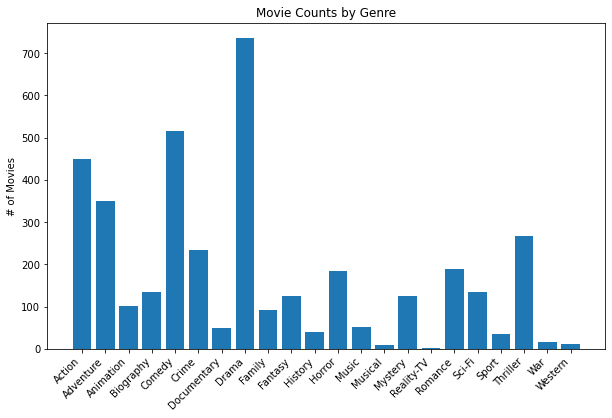

In [5]:
# Movie Counts by Genre - bar chart

genre_counts = genres_df.groupby('genres')['primary_title'].count()

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(genre_counts.index, genre_counts.values)
ax.set_title('Movie Counts by Genre')
ax.set_ylabel('# of Movies')
ax.set_xticklabels(genre_counts.index, rotation=45, ha='right')
plt.show()

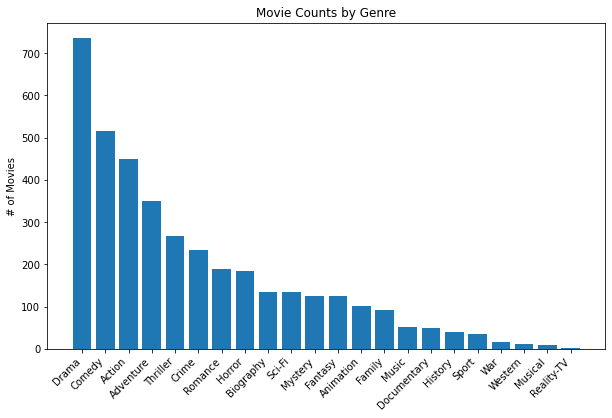

In [6]:
# Movie Counts by Genre - bar chart
# same as above using plt

genre_counts = genres_df.groupby('genres')['primary_title'].count()
genre_counts = genre_counts.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(genre_counts.index, genre_counts.values)
plt.title('Movie Counts by Genre')
plt.ylabel('# of Movies')
plt.xticks(rotation=45, ha='right')
plt.show()

In [7]:
# Movie Rating vs. ROI - scatter plot

plt.figure(figsize=(10, 6))
plt.scatter(movie_df['averagerating'], movie_df['ROI'], alpha=0.5)
plt.title('Movie Rating vs. ROI')
plt.xlabel('Movie Rating')
plt.ylabel('ROI (%)')
plt.grid(True)
plt.show()

KeyError: 'averagerating'

<Figure size 720x432 with 0 Axes>

In [ ]:
# Vote Count vs. ROI - scatter plot

plt.figure(figsize=(10, 6))
plt.scatter(movie_df['numvotes'], movie_df['ROI'], alpha=0.5)
plt.title('Vote Count vs. ROI')
plt.xlabel('# of Votes (M)')
plt.ylabel('ROI (%)')
plt.grid(True)
plt.show()


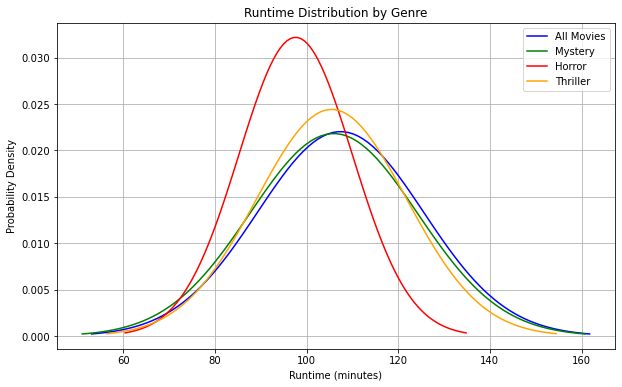

In [27]:
# Runtime Distribution by Genre - bell curve

# Create df for each top genre
mystery_df = genres_df[genres_df['genres'] == 'Mystery']
horror_df = genres_df[genres_df['genres'] == 'Horror']
thriller_df = genres_df[genres_df['genres'] == 'Thriller']

# Calculate data for all movies
mean_all = movie_df['runtime_minutes'].mean()
std_dev_all = movie_df['runtime_minutes'].std()
x_all = np.linspace(mean_all - 3 * std_dev_all, mean_all + 3 * std_dev_all, 100)
y_all = norm.pdf(x_all, mean_all, std_dev_all)

mean_mystery = mystery_df['runtime_minutes'].mean()
std_dev_mystery = mystery_df['runtime_minutes'].std()
x_mystery = np.linspace(mean_mystery - 3 * std_dev_mystery, mean_mystery + 3 * std_dev_mystery, 100)
y_mystery = norm.pdf(x_mystery, mean_mystery, std_dev_mystery)

mean_horror = horror_df['runtime_minutes'].mean()
std_dev_horror = horror_df['runtime_minutes'].std()
x_horror = np.linspace(mean_horror - 3 * std_dev_horror, mean_horror + 3 * std_dev_horror, 100)
y_horror = norm.pdf(x_horror, mean_horror, std_dev_horror)

mean_thriller = thriller_df['runtime_minutes'].mean()
std_dev_thriller = thriller_df['runtime_minutes'].std()
x_thriller = np.linspace(mean_thriller - 3 * std_dev_thriller, mean_thriller + 3 * std_dev_thriller, 100)
y_thriller = norm.pdf(x_thriller, mean_thriller, std_dev_thriller)

# Plotting the bell curve
plt.figure(figsize=(10, 6))
plt.plot(x_all, y_all, label='All Movies', color='blue')
plt.plot(x_mystery, y_mystery, label='Mystery', color='green')
plt.plot(x_horror, y_horror, label='Horror', color='red')
plt.plot(x_thriller, y_thriller, label='Thriller', color='orange')
plt.title('Runtime Distribution by Genre')
plt.xlabel('Runtime (minutes)')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True)
plt.show()


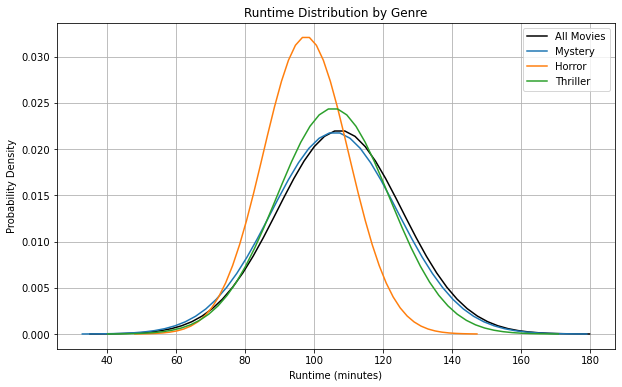

In [11]:
# LETS GOOO

def plot_genres_runtime():
    
    # Ask for user input of genres to plot and create list of string values
    input_genres = input("Enter genres (comma-separated): ")
    input_genres = [genre.strip().title() for genre in input_genres.split(',')]

    # Create chart
    plt.figure(figsize=(10, 6))
    plt.title('Runtime Distribution by Genre')
    plt.xlabel('Runtime (minutes)')
    plt.ylabel('Probability Density')

    # Plot bell curve for overall movies runtime
    mean = movie_df['runtime_minutes'].mean()
    std_dev = movie_df['runtime_minutes'].std()
    x = np.linspace(mean-(4*std_dev), mean+(4*std_dev))
    y = norm.pdf(x, mean, std_dev)
    plt.plot(x, y, label='All Movies', color='black')

    # Calculate data and plot for each input genre
    for genre in input_genres:
        mean_genre = genres_df.loc[genres_df['genres'] == genre, 'runtime_minutes'].mean()
        std_dev_genre = genres_df.loc[genres_df['genres'] == genre, 'runtime_minutes'].std()
        x_genre = np.linspace(mean_genre-(4*std_dev_genre), mean_genre+(4*std_dev_genre))
        y_genre = norm.pdf(x_genre, mean_genre, std_dev_genre)
        plt.plot(x_genre, y_genre, label=genre)

    # Show chart  
    plt.legend()
    plt.grid()
    plt.show()


plot_genres_runtime()
# mystery, horror, thriller

In [26]:
# Calculate genre frequencies
genre_counts = genres_df['genres'].value_counts()

# Calculate genre percentages
genre_percentages = genre_counts / len(genres_df['primary_title'].unique()) * 100

genre_percentages


Drama          49.623029
Comedy         35.023989
Action         30.637423
Adventure      23.920493
Thriller       18.026045
Crime          16.038382
Romance        12.816998
Horror         12.474297
Biography       9.115833
Sci-Fi          9.115833
Mystery         8.636052
Fantasy         8.430432
Animation       6.922550
Family          6.374229
Music           3.289925
History         2.673064
Documentary     2.467443
Sport           2.330363
War             1.165182
Western         0.753941
Musical         0.616861
Name: genres, dtype: float64